In [123]:
import networkx as nx
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name',
                    'landuse', 'width', 'est_width', 'junction', 'surface',
                    'traffic_signals', 'crossing', 'railway']


ox.settings.useful_tags_way=useful_tags_path

def generate_streetnetwork():

    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary|tertiary|residential|busway"]'


    ox.settings.log_console=True
    ox.settings.use_cache=True
    # ox.config(use_cache=True, log_console=True)

    # download street network data from OSM and construct a MultiDiGraph model
   #G = ox.graph_from_address('Rotterdam, Netherlands', dist=8000, network_type='drive', simplify=True, custom_filter=cf)
    G = ox.graph_from_bbox(51.9248, 51.8048, 4.4699, 4.5899, network_type='drive', simplify=True, custom_filter=cf)


    # default speeds
    hwy_speeds = {'motorway': 100,
                    'trunk': 100,
                    'primary': 80,
                    'secondary': 50,
                    'residential': 30,
                    'tertiary': 50,
                    'busway':50}


    G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G, precision=1)

    return G

In [124]:
def save_graph(G):
    filepath=f"./graphs/Rotterdam.graph.graphml"
    # ox.save_graph_geopackage(G, filepath=filepath)
    ox.save_graphml(G,filepath)

In [125]:
def draw_edges(graph):
    edges_fugitive = []

    edge_colormap = ['lightgray'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [126]:
G=generate_streetnetwork()

In [127]:
save_graph(G)

In [128]:
def show_graph():
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    config = 3
    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, 4.5028, 51.8857)  # random coordinaat in bounding box

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('red')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f"./graphs/prelim_Rotterdam.png"
                )

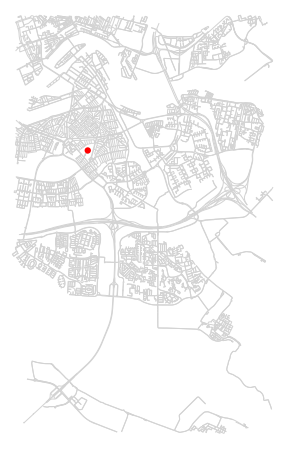

In [129]:
show_graph()

In [130]:
exit_nodes = []
for node in G.nodes():
    succ_nodes = [a for a in G.succ[node]]
    succ_nodes_type = [G.succ[node][b][0]['highway'] for b in succ_nodes]

    pred_nodes = [a for a in G.pred[node]]
    pred_nodes_type = [G.pred[node][b][0]['highway'] for b in pred_nodes]

    total_nodes_type = succ_nodes_type + pred_nodes_type
# check of er geen snelweg aanwezig is als de voorganger van een node
    if 'motorway' in total_nodes_type and any([x != 'motorway' or 'trunk' for x in pred_nodes_type]):
        exit_nodes.append(node)

len(exit_nodes)

59

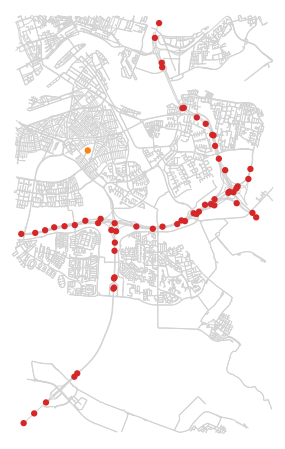

In [131]:
def show_graph(G):
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    config = 3

    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, 4.5028, 51.8857)  # bank

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in exit_nodes:
            node_size.append(40)
            node_color.append('tab:red')
#trunk nodes worden niet op de kaart getoond, zodat de exit nodes mooi op de Ring van Rotterdam liggen (dit is vanaf waar een fugitive is ontkomen of al gepakt moet zijn)
    #    elif node in trunk_nodes:
    #        node_size.append(40)
    #        node_color.append('tab:red')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'./graphs/Rotterdam.png'
                )
    # ax.savefig('graphs/FLEE/Graph_FLEE.png')

show_graph(G)

In [132]:
import pickle
#escape_nodes = list(set(exit_nodes).union(set(trunk_nodes)))
#escape_nodes liggen alleen op snelwegen
escape_nodes = list(set(exit_nodes))
with open('data/escape_nodes_Rotterdam.pkl', 'wb') as f:
    pickle.dump(escape_nodes, f)

suspect_start = ox.nearest_nodes(G, 4.5028, 51.8857)  # bank
with open('data/fugitive_start_Rotterdam.pkl', 'wb') as f:
    pickle.dump(suspect_start, f)

In [133]:
import geopandas as gpd
import shapely

filepath=f"graphs/Rotterdam.graph.graphml"
G = ox.load_graphml(filepath=filepath)

In [134]:
nodes_gdf, streets = ox.graph_to_gdfs(G, nodes=True, edges=True,
                            node_geometry=False, fill_edge_geometry=True)
streets = streets.to_crs(4326)
streets

osmid  \
u           v          key                                                      
26673101    44255519   0                                              7326213   
26911590    44412339   0                                              7521379   
            44409291   0                                              7523166   
            44408715   0                                              7523171   
29335572    44265387   0                                              7326088   
...                                                                       ...   
11470204952 44377330   0    [7514177, 255344100, 255344101, 255344103, 751...   
            6267769724 0                 [1235574732, 1235574733, 1235574734]   
11512131615 44246410   0                                              7322496   
11809547431 44398261   0                               [134951121, 510807166]   
11820104975 2791449888 0                                           1272892840   

                                                                     name  \
u           v          key                                                  
26673101    44255519   0                                    Streijenhagen   
26911590    44412339   0                                   Achterklooster   
            44409291   0                                        Kipstraat   
            44408715   0                                     Mariniershof   
29335572    44265387   0                                    Frambozentuin   
...                                                                   ...   
11470204952 44377330   0    [Ketelaarsstraat, Blekerstraat, 1e Blekerhof]   
            6267769724 0                               Hoornbrekersstraat   
11512131615 44246410   0                                       Spuistraat   
11809547431 44398261   0                                             Kolk   
11820104975 2791449888 0                                       Pampuskade   

                                highway maxspeed        surface  oneway  \
u           v          key                                                
26673101    44255519   0    residential       30  paving_stones   False   
26911590    44412339   0    residential       30  paving_stones   False   
            44409291   0    residential       30  paving_stones   False   
            44408715   0    residential       30  paving_stones   False   
29335572    44265387   0    residential       30  paving_stones   False   
...                                 ...      ...            ...     ...   
11470204952 44377330   0    residential       50            NaN   False   
            6267769724 0    residential       30            NaN   False   
11512131615 44246410   0    residential       30  paving_stones   False   
11809547431 44398261   0    residential      NaN  paving_stones   False   
11820104975 2791449888 0    residential      NaN            NaN   False   

                             length  \
u           v          key            
26673101    44255519   0     62.725   
26911590    44412339   0    115.110   
            44409291   0     28.554   
            44408715   0     97.694   
29335572    44265387   0     72.338   
...                             ...   
11470204952 44377330   0    221.312   
            6267769724 0    154.209   
11512131615 44246410   0     69.447   
11809547431 44398261   0     48.882   
11820104975 2791449888 0     97.254   

                                                                     geometry  \
u           v          key                                                      
26673101    44255519   0    LINESTRING (4.55610 51.88856, 4.55602 51.88875...   
26911590    44412339   0      LINESTRING (4.49196 51.92262, 4.49348 51.92306)   
            44409291   0      LINESTRING (4.49196 51.92262, 4.49214 51.92239)   
            44408715   0      LINESTRING (4.49196 51.92262, 4.49063 51.92231)   
29335572    44265387   0    LINESTRING (4.5566

In [135]:
# import geopackage file in geopandas
nld = gpd.read_file("geodata/rotterdamtest1.geojson", layer=0)
# nld = gpd.read_file("graphs/FLEE/Netherlands_shapefile/nl_1km.shp")
nld = nld.to_crs(4326)
nld

,geometry
0,"POLYGON ((4.48104 51.91068, 4.49927 51.86425, ..."


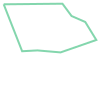

In [136]:
#de getekende grenzen van Rotterdam laten zien
multiLines = shapely.geometry.MultiLineString([x.exterior for x in nld.geometry])
multiLines

In [137]:
lines = streets.geometry.unary_union
intersection = lines.intersection(nld.geometry[0])
# [p for p in intersection.geoms]
type(intersection)

shapely.geometry.multilinestring.MultiLineString

In [138]:
intersectionn = gpd.sjoin(streets, nld)

<AxesSubplot:>

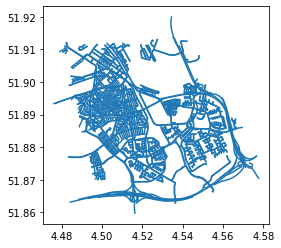

In [139]:
intersectionn.plot()

In [140]:
unique_osmids_u = list(intersectionn.index.unique(level=0))
unique_osmids_v = list(intersectionn.index.unique(level=1))
unique_osmids = list(set(unique_osmids_u) | set(unique_osmids_v))
# nodes_gdf.iloc[unique_osmids]
nodes_gdf_intersection = nodes_gdf[nodes_gdf.index.isin(unique_osmids)]

In [141]:
len(unique_osmids)

2082

In [142]:
nodes_gdf_intersection

,y,x,street_count,ref,highway
osmid,,,,,
26673101,51.888562,4.556098,1,NaN,NaN
29335572,51.890354,4.556670,1,NaN,NaN
29335597,51.889970,4.554568,1,NaN,NaN
29335612,51.889823,4.553497,1,NaN,NaN
44130602,51.859544,4.516248,3,NaN,motorway_junction
...,...,...,...,...,...
10800073750,51.870798,4.547156,3,NaN,NaN
10834188779,51.899437,4.508597,1,NaN,NaN
11323227675,51.885870,4.545155,4,NaN,NaN


In [143]:
G_intersection = ox.graph_from_gdfs(nodes_gdf_intersection, intersectionn)

In [144]:
len(G_intersection.nodes())

2082

In [145]:
save_graph(G_intersection)

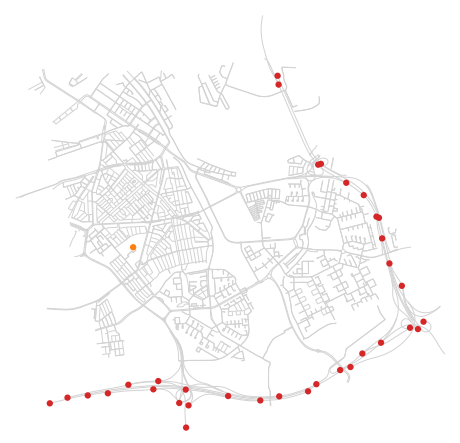

In [146]:
show_graph(G=G_intersection)

In [147]:
cameras_df= pd.read_excel(f'./data/cameras_rotterdam.xlsx')
cameras_df
len(cameras_df)

76

In [148]:
for index, row in cameras_df.iterrows():
    if row['Latitude'] < 51.8048 or row['Latitude'] > 51.9248 :
        df_fixed = cameras_df.drop(index)
    elif row['Longitude'] < 4.4699  or row['Longitude'] > 4.5899:
        cameras_df = cameras_df.drop(index)

In [149]:
len(cameras_df)

38

In [150]:
cameras = []
for index, row in cameras_df.iterrows():
   # if row['Soort'] != 'ANPR-camera':
    #    continue

    lat = float(row['Latitude'])
    lon = float(row['Longitude'])
    closest_node = ox.nearest_nodes(G, lon, lat)
    cameras.append(closest_node)

cameras = list(set(cameras))
cameras

[670854722,
 44179482,
 1435580676,
 44355197,
 44291181,
 44349037,
 3491058835,
 44310675,
 44294838,
 44420537,
 5491722746,
 307156957,
 44421118]

In [151]:
with open(f'./data/cameras_Rotterdam.pkl', 'wb') as f:
    pickle.dump(cameras, f)

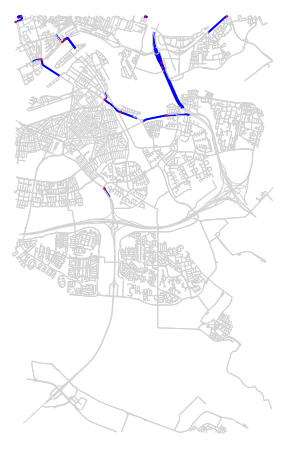

[(44161419, 44179482), (44179482, 44185548), (44179482, 44187119), (44291181, 44290956), (44291181, 44290473), (44293929, 44294838), (44294838, 678516294), (44294838, 44298096), (44310675, 44311061), (44310675, 770739508), (44349037, 44299057), (44355197, 44370966), (44355197, 44392228), (44385087, 670854722), (44385087, 307156957), (44397464, 44349037), (44418776, 5491722746), (44420537, 1555848129), (44420537, 44420537), (44420537, 44420537), (44421118, 44421119), (44421119, 44421118), (289070523, 44355197), (307156957, 768935955), (307156957, 44395387), (603233386, 44310675), (670854722, 307156957), (670854722, 9402428440), (678516294, 44310675), (987014909, 44349037), (1120496427, 44421118), (1435580676, 1426610336), (1435580676, 1435580711), (1435580729, 1435580676), (1555848129, 44420537), (1555848129, 3491058835), (1612095282, 1435580676), (1687745613, 44291181), (1721153936, 44294838), (3491058835, 4127740927), (5491722745, 5491722746), (5491722746, 44418776), (5491722746, 5491

In [152]:
fig, ax = plt.subplots(figsize=(15, 8))
edge_size = []
edge_width = []
node_color = []
camera_edges = [] #create a list with roads that are controlled by ANPR-cameras, so those specific edges can be avoided
for u,v in G.edges():
    if u in cameras:
        edge_size.append("blue")
        edge_width.append(2)
        camera_edges.append((u, v))
    elif v in cameras:
        edge_size.append("blue")
        edge_width.append(2)
        camera_edges.append((u,v))
    else:
        edge_size.append("lightgray")
        edge_width.append(1)

node_color = ["red" if node in cameras else "lightgray" for node in G.nodes()]
node_size = [5 if node in cameras else 0 for node in G.nodes()]

ox.plot.plot_graph(
                G, ax=ax,
                bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_width, edge_color=edge_size,
                save=True, filepath="cameras.png"
            )
print(camera_edges)

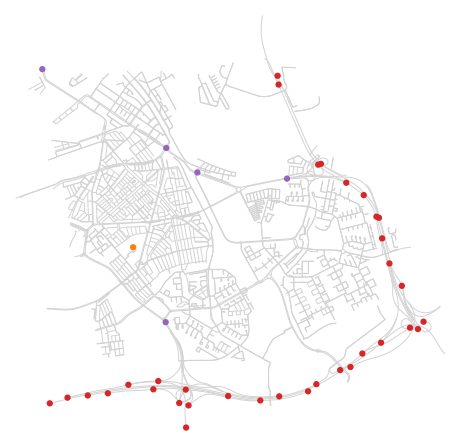

In [153]:
def show_graph(G, escape_nodes, cameras):
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, 4.5028, 51.8857)

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')
        elif node in cameras:
            node_size.append(40)
            node_color.append('tab:purple')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'./graphs/Rotterdam.png'
                )
    # ax.savefig('graphs/FLEE/Graph_FLEE.png')

show_graph(G_intersection, escape_nodes, cameras)

Enrich_graph_cool:

In [154]:
import networkx as nx
import numpy as np
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import pickle

In [155]:
city = 'Rotterdam'
#city_str = 'Rotterdam, Netherlands'
#dist = 8000

In [156]:
filepath=f"./graphs/Rotterdam.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
G = ox.load_graphml(filepath=filepath)

with open(f'./data/escape_nodes_Rotterdam.pkl', 'rb') as f:
    escape_nodes = pickle.load(f)

with open(f'./data/fugitive_start_Rotterdam.pkl', 'rb') as f:
    fugitive_start = pickle.load(f)

with open(f'./data/cameras_Rotterdam.pkl', 'rb') as f:
    cameras = pickle.load(f)


In [157]:
len(escape_nodes)

59

In [158]:
escape_nodes_filtered = []
for escape_node in escape_nodes:
    if G.has_node(escape_node):
        escape_nodes_filtered.append(escape_node)

with open('data/escape_nodes_{city}_filtered.pkl', 'wb') as f:
    pickle.dump(escape_nodes_filtered, f)

In [159]:
len(escape_nodes_filtered)

34

In [160]:
escape_nodes = escape_nodes_filtered.copy()

In [161]:
def draw_edges(graph):
    edges_fugitive = []

    # for i_r, route_time in enumerate(fugitive_routes):
    #     route = list(route_time.values())
    #     for i, node in enumerate(route):
    #         if i ==0:
    #             continue
    #         else:
    #             edges_fugitive1 = [(route[i], route[i-1])]
    #             edges_fugitive2 = [(route[i-1], route[i])]
    #             edges_fugitive.extend(tuple(edges_fugitive1))
    #             edges_fugitive.extend(tuple(edges_fugitive2))

    edge_colormap = ['lightgray'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [162]:
def draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes):
    node_size = []
    node_color = []
    for node in G.nodes:
        if node == fugitive_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')
        elif node in cameras:
            node_size.append(10)
            node_color.append('tab:green')
        elif node in trafficlights:
            node_size.append(10)
            node_color.append('purple')
        elif node in roundabouts:
            node_size.append(10)
            node_color.append('gold')
        elif node in tunnels:
            node_size.append(10)
            node_color.append('aqua')
        elif node in bridges:
            node_size.append(10)
            node_color.append('royalblue')
        else:
            node_size.append(0)
            node_color.append('lightgray')
    return node_size, node_color

In [163]:
from matplotlib.lines import Line2D

def show_graph(G, escape_nodes, fugitive_start, cameras, trafficlights, roundabouts, bridges, tunnels, save=False): #cameras,
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    edge_colormap, edge_weightmap = draw_edges(G)
    node_size, node_color = draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes)
 #   node_size, node_color = draw_nodes(G, fugitive_start, trafficlights, roundabouts, tunnels, bridges, escape_nodes)

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                )
    if save:

        custom_lines = [Line2D([0], [0], color='tab:orange', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='tab:red', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='tab:green', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='purple', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='gold', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='aqua', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='royalblue', marker='o', markersize=10, linestyle=''),
                        ]
        labels = ['start fugitive', 'escape node', 'cameras', 'traffic light', 'roundabout', 'tunnel', 'bridge'] # 'camera' op 3e plaats
        ax.legend(custom_lines, labels, bbox_to_anchor=(1.1, 1.05))
        fig.savefig(f'graphs/{city}.png', bbox_inches='tight', dpi=300)

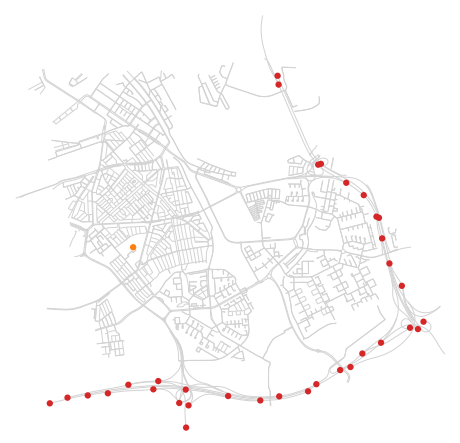

In [164]:
show_graph(G, escape_nodes, fugitive_start, [], [], [], [], [], save=False)

In [165]:
roundabouts = []
for u,v, data in G.edges(data=True):
    if 'junction' in data.keys():
        if data['junction'] == 'roundabout':
            roundabouts.append(u)
            roundabouts.append(v)

roundabouts = np.unique(roundabouts)

In [166]:
with open(f'./model_elements/roundabouts.pkl', 'wb') as f:
    pickle.dump(roundabouts, f)

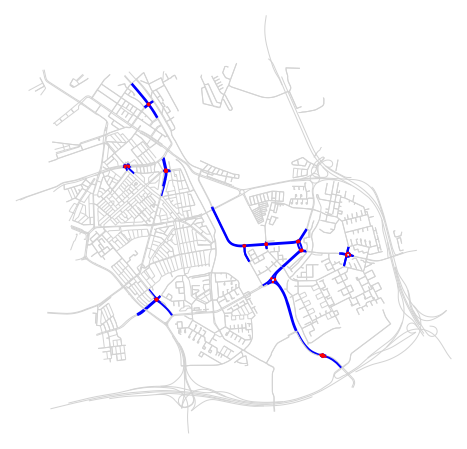

In [167]:
fig, ax = plt.subplots(figsize=(15, 8))
edge_size = []
edge_width = []
for u,v in G.edges():
    if u in roundabouts:
        edge_size.append("blue")
        edge_width.append(2)
    elif v in roundabouts:
        edge_size.append("blue")
        edge_width.append(2)
    else:
        edge_size.append("lightgray")
        edge_width.append(1)


node_color = ["red" if node in roundabouts else "lightgray" for node in G.nodes()]
node_size = [5 if node in roundabouts else 0 for node in G.nodes()]

ox.plot.plot_graph(
                G, ax=ax,
                bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_width, edge_color=edge_size,
                save=True, filepath="roundabouts.png"
            );

In [168]:
import networkx as nx
import osmnx as ox

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name'
                    'landuse', 'width', 'est_width', 'junction', 'surface',
                    'traffic_signals', 'crossing']

ox.settings.useful_tags_way=useful_tags_path

def generate_streetnetwork(city_str, dist):
    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary|tertiary|residential|busway"]'

    ox.settings.log_console=True
    ox.settings.use_cache=True

    # download street network data from OSM and construct a MultiDiGraph model
    #G = ox.graph_from_address(city_str, dist=dist, network_type='drive', simplify=False, custom_filter=cf)
    G = ox.graph_from_bbox(51.9248, 51.8048, 4.4699, 4.5899, network_type='drive', simplify=False, custom_filter=cf)

    return G

G_notsimplified=generate_streetnetwork('Rotterdam', 3000)

In [169]:
len(G.nodes())

2082

In [170]:
trafficlight_locs = []
for u, data in G_notsimplified.nodes(data=True):
    if 'traffic_signals' in data.keys():
        trafficlight_locs.append(data)
    elif 'highway' in data.keys():
        if data['highway'] == 'traffic_signals':
            trafficlight_locs.append(data)
    elif 'crossing' in data.keys():
        if data['crossing'] == 'traffic_signals':
            trafficlight_locs.append(data)

In [171]:
import osmnx as ox
import numpy as np

trafficlights = []

# Loop door elk element in de lijst trafficlight_locs
for trafficlight_loc in trafficlight_locs:
    # Haal de y- en x-coördinaten uit elk element
    y_coord = trafficlight_loc['y']
    x_coord = trafficlight_loc['x']

    # Bereken de afstand tussen elk knooppunt en de gegeven coördinaten
    node_distances = {}
    for node in G.nodes():
        if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
            node_y = G.nodes[node]['y']
            node_x = G.nodes[node]['x']
            distance = np.sqrt((y_coord - node_y)**2 + (x_coord - node_x)**2)
            node_distances[node] = distance

    nearest_node = min(node_distances, key=node_distances.get)
    trafficlights.append(nearest_node)

trafficlights = np.unique(trafficlights)

In [172]:
trafficlight_locs

[{'y': 51.8137989,
  'x': 4.4949638,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.873565,
  'x': 4.4779931,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.8752818,
  'x': 4.510776,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.8756086,
  'x': 4.510855,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.8851712,
  'x': 4.4918709,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.88994,
  'x': 4.5078253,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.8902799,
  'x': 4.4852927,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.8905608,
  'x': 4.5147728,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.8981433,
  'x': 4.5495224,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.9003446,
  'x': 4.5112054,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y': 51.9140174,
  'x': 4.5369214,
  'highway': 'traffic_signals',
  'street_count': 2},
 {'y

In [173]:
len(trafficlights)

159

In [174]:
with open(f'./model_elements/trafficlights.pkl', 'wb') as f:
    pickle.dump(trafficlights, f)

In [175]:
tunnels = []
for u, v, data in G.edges(data=True):
    if 'tunnel' in data.keys():
        tunnels.append(u)
        tunnels.append(v)

tunnels = np.unique(tunnels)

In [176]:
import pandas as pd
from pandas.io.json import json_normalize
import json

bridges_path = f'./data/bridges_rotterdam.json'
with open(bridges_path, 'r') as json_bestand:
    data = json.load(json_bestand)

# converteer json bestand naar een DataFrame
bridges_dataframe = json_normalize(data)

bridges_dataframe = bridges_dataframe[bridges_dataframe['type']=='node']
bridges_dataframe = bridges_dataframe[['id','lat','lon']]
bridges_dataframe

C:\Users\Veerle\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,id,lat,lon
23,5313597287,51.906264,4.448596
24,5313597288,51.906276,4.448055
25,5313597289,51.906242,4.448055
26,5313597290,51.906232,4.448592
27,8437277790,51.916638,4.443798
...,...,...,...
146,2405631460,51.921322,4.498191
147,2405631461,51.921037,4.498107
148,2405631469,51.921119,4.498362
149,745637382,51.955601,4.518518


In [177]:
bridges = []
for i in bridges_dataframe:
    dichtstbijzijnde_node = ox.nearest_nodes(G, bridges_dataframe['lon'], bridges_dataframe['lat'])
    bridges.append(dichtstbijzijnde_node)
bridges = np.unique(bridges)

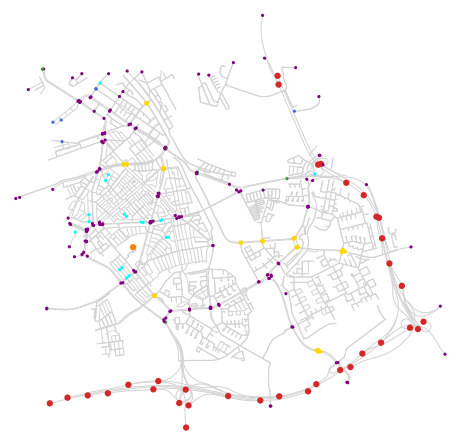

In [178]:
show_graph(G, escape_nodes, fugitive_start, cameras, trafficlights, roundabouts, bridges, tunnels, save=False)

In [179]:
camera_extra_time = 30
roundabout_extra_time = 5
trafficlight_extra_time = 10
tunnel_extra_time = 5
bridge_extra_time = 0

travel_time_dict = {}
for u, v, data in G.edges(data=True):
    travel_time_adj = data['travel_time']

    if data['highway'] in ['motorway', 'trunk', 'primary']:
        travel_time_adj += 40

  #  if u in cameras:
   #     travel_time_adj += camera_extra_time
    if u in trafficlights:
        travel_time_adj += trafficlight_extra_time
    if u in roundabouts:
        travel_time_adj += roundabout_extra_time
    if u in tunnels:
        travel_time_adj += tunnel_extra_time
    if u in bridges:
        travel_time_adj += bridge_extra_time

   # if v in cameras:
   #     travel_time_adj += camera_extra_time
    if v in trafficlights:
        travel_time_adj += trafficlight_extra_time
    if v in roundabouts:
        travel_time_adj += roundabout_extra_time
    if v in tunnels:
        travel_time_adj += tunnel_extra_time
    if v in bridges:
        travel_time_adj += bridge_extra_time

    travel_time_dict[(u, v, 0)] = float(travel_time_adj)

nx.set_edge_attributes(G, travel_time_dict, "travel_time_adj")

In [180]:
len(escape_nodes)

34

In [181]:
#OUDE CODE VOOR BEREKENEN KORTSTE ROUTE --> zonder traffic conditions
route_fugitive = []
while len(route_fugitive) < 8: #normaal is dit 1000
   for escape_node in escape_nodes_filtered:
       try:
           path = nx.shortest_path(G, fugitive_start, escape_node, 'travel_time_adj')
           # [escape_routes.append(path) for path in nx.all_simple_paths(G, fugitive_start, escape_node)]
           route_fugitive.append(path)
       except:
           continue

In [182]:
H = G.copy()

In [183]:
#On roundabouts, the maximum speed is not reachable. So, for 50km/h roundabouts, a speed of 30 is set, and roundabouts of 80km/h a speed of 50km/h will be used
for u, v, data in H.edges(data=True):
    if u in roundabouts and v in roundabouts:
        if data['maxspeed'] == 50:
            data['maxspeed'] = 30
            data['speed_kph'] = 30
        if data['maxspeed'] == 80:
            data['maxspeed'] = 50
            data['speed_kph'] = 50
        print(data)

{'osmid': 7326025, 'highway': 'secondary', 'maxspeed': '80', 'oneway': True, 'length': 26.312, 'geometry': <shapely.geometry.linestring.LineString object at 0x000002A186BD9F08>, 'speed_kph': 80.0, 'travel_time': 1.2, 'lanes': '1', 'ref': 'S104', 'junction': 'roundabout', 'index_right': '0', 'travel_time_adj': 11.2}
{'osmid': 1222844485, 'highway': 'secondary', 'maxspeed': '80', 'oneway': True, 'length': 6.372, 'geometry': <shapely.geometry.linestring.LineString object at 0x000002A186BD9788>, 'speed_kph': 80.0, 'travel_time': 0.3, 'lanes': '1', 'ref': 'S104', 'junction': 'roundabout', 'index_right': '0', 'travel_time_adj': 10.3}
{'osmid': [1222844484, 1161177413], 'name': 'IJsselmondse Randweg', 'highway': 'secondary', 'maxspeed': '80', 'oneway': True, 'length': 43.373999999999995, 'geometry': <shapely.geometry.linestring.LineString object at 0x000002A186BD9208>, 'speed_kph': 80.0, 'travel_time': 2.0, 'lanes': '1', 'ref': 'S104', 'junction': 'roundabout', 'index_right': '0', 'travel_tim

In [184]:
#NIEUWE CODE VOOR BEREKENEN KORTSTE ROUTE DIE WEGEN MET ANPR-CAMERAS NIET MEENEEMT
# H.remove_edges_from(camera_edges)
# route_fugitive = []
# while len(route_fugitive) < 8: # normaal is dit 1000
#     for escape_node in escape_nodes_filtered:
#         try:
#             path = nx.shortest_path(H, fugitive_start, escape_node, 'travel_time')
#             route_fugitive.append(path)
#         except:
#             continue


In [185]:
len(route_fugitive)

21

In [186]:
with open(f'data/escape_routes_{city}.pkl', 'wb') as f:
    pickle.dump(route_fugitive, f)

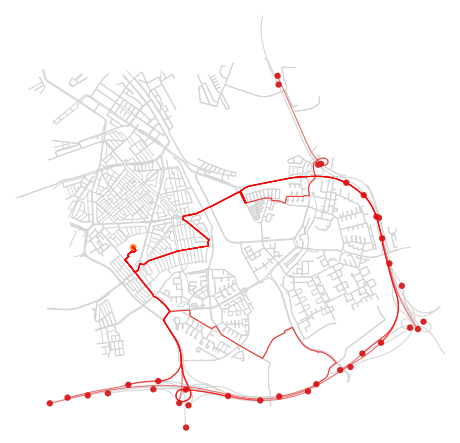

In [187]:
# # nx.draw_networkx_edges(G,edgelist=path_edges,edge_color='r',width=10)
#node_size, node_color = draw_nodes(G, fugitive_start, [], [], [], [], [], escape_nodes)
#G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes): #cameras
node_size, node_color = draw_nodes(G, fugitive_start, [], [], [], [], [], escape_nodes)
edge_colormap, edge_weightmap = draw_edges(G)

fig, ax = ox.plot_graph_routes(G, route_fugitive,
                               route_linewidths=1, orig_dest_size=0,
                               edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                               node_color=node_color, node_size=node_size,
                               bgcolor="white", )

fig.savefig(f'{city}_cool.png', bbox_inches='tight', dpi=300)


In [188]:
filepath=f"./graphs/{city}_prepped.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
ox.save_graphml(G,filepath)

In [189]:
politie_bureau = []
delay = []
locations6 = [(4.48020, 51.92399),(4.49594, 51.90196), (4.47949, 51.94326), (4.49053, 51.88925), (4.55229, 51.94875), (4.482000, 51.8756)]
locations3 = [(4.48020, 51.92399),(4.49594, 51.90196), (4.49053, 51.88925)]
locations = [(4.553520228058219, 51.88094091945676)]
for location in locations:
    dichtstbijzijnde_node = ox.nearest_nodes(G, location[0], location[1])
    politie_bureau.append(dichtstbijzijnde_node)
    delay.append(0)
    print(dichtstbijzijnde_node)

with open(f'./data/optimization/start_police_Rotterdam.pkl', 'wb') as f:
    pickle.dump(politie_bureau, f)

with open(f'./data/optimization/delays_police_Rotterdam.pkl', 'wb') as f:
    pickle.dump(delay, f)

44211293


In [190]:
police_travel_time_dict = {}
for u, v, z, data in G.edges(data=True,keys=True):
    police_travel_time = (data['travel_time']/2)
  #  print(data['travel_time'],police_travel_time)
    police_travel_time_dict[(u, v, z)] = float(police_travel_time)
    #print('de politierijtijd van',({u},{v}), 'is', data['police_travel_time'])


nx.set_edge_attributes(G, police_travel_time_dict, "police_travel_time")
#print(police_travel_time_dict)

#for u, v, data in G.edges(data=True):
 #   print(f"Rand ({u}, {v}) heeft attributen: {data}")


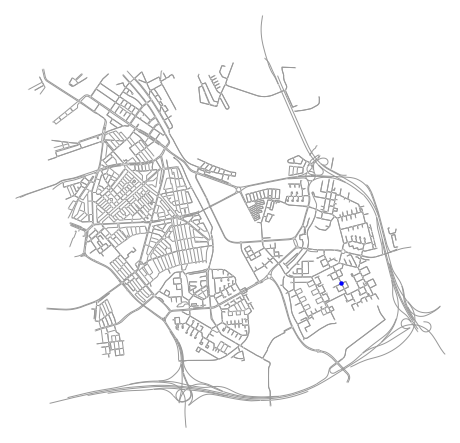

In [191]:
node_colors = ['blue' if node == 44211293 else 'lightgray' for node in G.nodes()]
node_sizes = [20 if node == 44211293 else 1 for node in G.nodes()]

ox.plot.plot_graph(
                G,
                bgcolor="white", node_color=node_colors, node_size=node_sizes,
                save=True, filepath="politiebureau.png"
            );

Traffic light categories

In [192]:
motorway_trafficlight_nodes = []

# Loop door elke node in de grafiek
for node in G_notsimplified.nodes():
    # Controleer of alle buren van de huidige node 'secondary' wegen zijn
    if all(data['highway'] == 'motorway' for _, _, data in G_notsimplified.edges(node, data=True)):
        # Voeg de node toe aan de lijst als alle buren 'secondary' wegen zijn en er een verkeerslicht op de node is
        if node in trafficlights:
            motorway_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
motorway_trafficlight_nodes = list(set(motorway_trafficlight_nodes))
print("Nodes waar alleen snelwegen samenkomen en waarop een verkeerslicht staat:", motorway_trafficlight_nodes)
print('Het zijn er', len(motorway_trafficlight_nodes))

Nodes waar alleen snelwegen samenkomen en waarop een verkeerslicht staat: [44164163, 44145003, 2603401292, 44170518]
Het zijn er 4


In [193]:
primary_trafficlight_nodes = []

# Loop door elke node in de grafiek
for node in G_notsimplified.nodes():
    # Controleer of alle buren van de huidige node 'primary' of 'trunk' wegen zijn
    if all(data['highway'] == 'primary' or data['highway'] == 'trunk' for _, _, data in G_notsimplified.edges(node, data=True)):
        # Voeg de node toe aan de lijst als alle buren 'primary' of 'trunk' wegen zijn en er een verkeerslicht op de node is
        if node in trafficlights:
            primary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primary_trafficlight_nodes = list(set(primary_trafficlight_nodes))
print("Nodes waar alleen 'primary' of 'trunk' wegen samenkomen en waarop een verkeerslicht staat:", primary_trafficlight_nodes)
print('Het zijn er', len(primary_trafficlight_nodes))

Nodes waar alleen 'primary' of 'trunk' wegen samenkomen en waarop een verkeerslicht staat: [1027160451, 5313487237, 1027160486, 2098302920, 1687745613, 10734992621, 1027160502, 1027160470, 1027231640, 1465648217, 2098302906]
Het zijn er 11


In [194]:
primarysecondary_trafficlight_nodes = []

# Loop door elke node in de grafiek
for node in G_notsimplified.nodes():
    primary_found = False
    secondary_found = False

    # Loop door alle buren van de huidige node
    for _, _, data in G_notsimplified.edges(node, data=True):
        # Controleer of er een weg van het type 'primary' of 'trunk' aansluit op de node
        if data.get('highway') in ['primary', 'trunk']:
            primary_found = True
        # Controleer of er een weg van het type 'secondary' aansluit op de node
        elif data.get('highway') == 'secondary':
            secondary_found = True

    # Voeg de node toe aan de lijst als zowel een 'primary' of 'trunk' weg als een 'secondary' weg aansluiten en er een verkeerslicht op de node is
    if primary_found and secondary_found and node in trafficlights:
        primarysecondary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primarysecondary_trafficlight_nodes = list(set(primarysecondary_trafficlight_nodes))
print("Nodes waar zowel 'primary' of 'trunk' als 'secondary' wegen samenkomen en waarop een verkeerslicht staat:", primarysecondary_trafficlight_nodes)
print('Het zijn er', len(primarysecondary_trafficlight_nodes))

Nodes waar zowel 'primary' of 'trunk' als 'secondary' wegen samenkomen en waarop een verkeerslicht staat: [44233216, 44235360, 1435580676, 1435580711, 44290473]
Het zijn er 5


In [195]:
primarytertiary_trafficlight_nodes = []

# Loop door elke node in de grafiek
for node in G_notsimplified.nodes():
    primary_found = False
    tertiary_found = False

    # Loop door alle buren van de huidige node
    for _, _, data in G_notsimplified.edges(node, data=True):
        # Controleer of er een weg van het type 'primary' of 'trunk' aansluit op de node
        if data.get('highway') in ['primary', 'trunk']:
            primary_found = True
        # Controleer of er een weg van het type 'tertiary' aansluit op de node
        elif data.get('highway') == 'tertiary':
            tertiary_found = True

    # Voeg de node toe aan de lijst als zowel een 'primary' of 'trunk' weg als een 'tertiary' weg aansluiten en er een verkeerslicht op de node is
    if primary_found and tertiary_found and node in trafficlights:
        primarytertiary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primarytertiary_trafficlight_nodes = list(set(primarytertiary_trafficlight_nodes))
print("Nodes waar zowel 'primary' of 'trunk' als 'tertiary' wegen samenkomen en waarop een verkeerslicht staat:", primarytertiary_trafficlight_nodes)
print('Het zijn er', len(primarytertiary_trafficlight_nodes))

Nodes waar zowel 'primary' of 'trunk' als 'tertiary' wegen samenkomen en waarop een verkeerslicht staat: [44262688, 44282082, 44262196]
Het zijn er 3


In [196]:
primaryresidential_trafficlight_nodes = []

# Loop door elke node in de grafiek
for node in G_notsimplified.nodes():
    residential_found = False
    primary_found = False

    # Loop door alle buren van de huidige node
    for _, _, data in G_notsimplified.edges(node, data=True):
        # Controleer of er een weg van het type 'residential' aansluit op de node
        if data.get('highway') == 'residential':
            residential_found = True
        # Controleer of er een weg van het type 'tertiary' aansluit op de node
        elif data.get('highway') == 'primary':
            primary_found = True

    # Voeg de node toe aan de lijst als zowel een 'residential' weg als een 'tertiary' weg aansluiten en er een verkeerslicht op de node is
    if residential_found and primary_found and node in trafficlights:
        primaryresidential_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primaryresidential_trafficlight_nodes = list(set(primaryresidential_trafficlight_nodes))
print("Nodes waar zowel 'residential' als 'primary' wegen samenkomen en waarop een verkeerslicht staat:", primaryresidential_trafficlight_nodes)
print('Het zijn er', len(primaryresidential_trafficlight_nodes))

Nodes waar zowel 'residential' als 'primary' wegen samenkomen en waarop een verkeerslicht staat: [44262688, 10703013793, 44257414, 734137895, 44244071, 44256947, 1456279827, 5313486109]
Het zijn er 8


Traffic light with tram

In [197]:
useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name',
                    'landuse', 'width', 'est_width', 'junction', 'surface',
                    'traffic_signals', 'crossing', 'railway',
                    'railway=tram', 'tram=yes', 'tram:lanes=*',
                    'highway=busway']


ox.settings.useful_tags_way=useful_tags_path

def generate_tramnetwork():

    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    railway_filter = '["railway"~"tram"]'


    ox.settings.log_console=True
    ox.settings.use_cache=True
    # ox.config(use_cache=True, log_console=True)

    # download street network data from OSM and construct a MultiDiGraph model
   #G = ox.graph_from_address('Rotterdam, Netherlands', dist=8000, network_type='drive', simplify=True, custom_filter=cf)
    T = ox.graph_from_bbox(51.9248, 51.8048, 4.4699, 4.5899, simplify=True, custom_filter=railway_filter)


    return T

In [198]:
T=generate_tramnetwork()

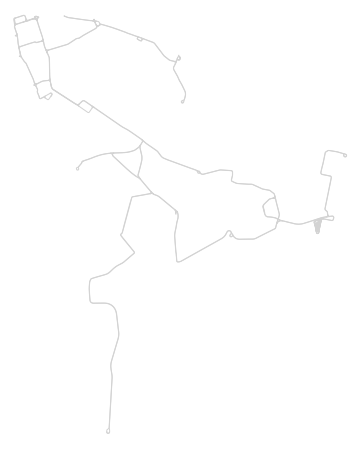

In [199]:
#Tramlijnen tekenen
fig, ax = ox.plot_graph(
   T, bgcolor="white", node_color="lightgray", node_size=1, edge_linewidth=1, edge_color="lightgray",
   save=False)

In [200]:
def get_node_coordinates(graph):
    coordinates = []
    for node, data in graph.nodes(data=True):
        coord = (data['y'], data['x'])
        coordinates.append(coord)
    return coordinates

node_coordinates = get_node_coordinates(T)

tram_nodes = []
for coord in node_coordinates:
    nearest_node = ox.nearest_nodes(G, coord[1], coord[0])
    tram_nodes.append(nearest_node)

In [201]:
intersection_with_tram = []
for node in tram_nodes:
    if node in trafficlights:
        intersection_with_tram.append(node)
intersection_with_tram

[1426610337,
 603233348,
 1435580676,
 2178103146,
 2178103146,
 44130602,
 44130602,
 4003289595,
 1426610335,
 44225957,
 1435580711,
 1687745613,
 1687745613,
 1435580676,
 1426610337,
 2178103146,
 2178103146,
 44357198,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 4003289595,
 1435580711,
 1435580676,
 1435580711,
 1435580711,
 1435580676,
 1435580676,
 1435580676,
 1435580676,
 1435580

In [202]:
with open(f'./model_elements/intersection_withtram.pkl', 'wb') as f:
    pickle.dump(intersection_with_tram, f)

In [203]:
#Bekijk hoe vaak een node in de lijst voorkomt, zodat de wachttijd hier afhankelijk gemaakt van kan worden
import collections
node_counts = collections.Counter(tram_nodes)

print("Aantal nodes waar trams overheen rijden:", len(tram_nodes))
print("Frequentie van elke node:")
for node, count in node_counts.items():
    print(f"Node {node} komt {count} keer voor")

Aantal nodes waar trams overheen rijden: 356
Frequentie van elke node:
Node 3359234389 komt 18 keer voor
Node 1426610337 komt 2 keer voor
Node 603233348 komt 2 keer voor
Node 1435580676 komt 115 keer voor
Node 2178103146 komt 9 keer voor
Node 44285739 komt 2 keer voor
Node 44130602 komt 2 keer voor
Node 44277892 komt 2 keer voor
Node 44305538 komt 3 keer voor
Node 4003289595 komt 9 keer voor
Node 44300259 komt 1 keer voor
Node 2026645467 komt 3 keer voor
Node 44218071 komt 3 keer voor
Node 44216590 komt 1 keer voor
Node 44359439 komt 8 keer voor
Node 44341365 komt 2 keer voor
Node 44230006 komt 3 keer voor
Node 1735588817 komt 3 keer voor
Node 1426610335 komt 3 keer voor
Node 735821605 komt 1 keer voor
Node 44225957 komt 1 keer voor
Node 4718288458 komt 15 keer voor
Node 1435580711 komt 12 keer voor
Node 1687745613 komt 2 keer voor
Node 44285197 komt 1 keer voor
Node 44292644 komt 3 keer voor
Node 8203472822 komt 19 keer voor
Node 2026645475 komt 2 keer voor
Node 44236665 komt 6 keer v

Green wave

In [204]:
traffic_lights_within_150m = []

# Itereer over elk paar stoplichten en controleer of er een kort pad is binnen 150 meter
for source in primary_trafficlight_nodes or primarysecondary_trafficlight_nodes or primarytertiary_trafficlight_nodes or primaryresidential_trafficlight_nodes:
    for target in primary_trafficlight_nodes or primarysecondary_trafficlight_nodes or primarytertiary_trafficlight_nodes or primaryresidential_trafficlight_nodes:
        if source != target and nx.has_path(G, source=source, target=target):
            path_length = nx.shortest_path_length(G, source=source, target=target, weight='travel_time')
            if path_length < 150:
                traffic_lights_within_150m.append(source)
                break  # Omdat we alleen willen weten of er een kort pad is, kunnen we stoppen met zoeken naar andere doelstoplichten

print(traffic_lights_within_150m)

[1027160451, 5313487237, 1027160486, 2098302920, 1687745613, 10734992621, 1027160502, 1465648217, 2098302906]


In [205]:
with open(f'./model_elements/green_wave.pkl', 'wb') as f:
    pickle.dump(traffic_lights_within_150m, f)

In [206]:
green_wave_road = []
cross_green_wave_road = []
for u,v,data in G.edges(data=True):
    if 'highway' in data.keys():
        if data['highway']=='primary' or data['highway']=='trunk':
            if u in traffic_lights_within_150m and v in traffic_lights_within_150m:
                green_wave_road.append([u,v])
        elif v in traffic_lights_within_150m:
            cross_green_wave_road.append([u,v])

print(green_wave_road)
print(cross_green_wave_road)

[[1027160451, 5313487237]]
[[2098302864, 2098302920], [44244781, 2098302906], [1027160420, 1027160451], [1456279827, 5313487237], [3665848146, 1687745613], [44293929, 1465648217]]


In [207]:
with open(f'./model_elements/green_wave_road.pkl', 'wb') as f:
    pickle.dump(green_wave_road, f)

with open(f'./model_elements/cross_green_wave_road.pkl', 'wb') as f:
    pickle.dump(cross_green_wave_road, f)

Default

In [208]:
default = []

for node in trafficlights:
    # Controleer of de node niet in een van de andere lijsten zit
    if node not in intersection_with_tram and node not in traffic_lights_within_150m:
        default.append(node)

with open(f'./model_elements/default.pkl', 'wb') as f:
    pickle.dump(default, f)


In [209]:
traffic_light_categories = {}

def add_nodes_to_dict(nodes, list_name):
    for node in nodes:
        if isinstance(node, (str, int, float, tuple, int, np.integer)):  # Controleren op valide datatypes inclusief numpy
            traffic_light_categories[node] = list_name
        elif isinstance(node, list) and all(isinstance(item, (str, int, float, tuple, np.integer)) for item in node):
            traffic_light_categories[tuple(node)] = list_name  # Converteer lijst naar tuple
        else:
            print(f"Skipping invalid node {node} in list {list_name}, type {type(node)}")

add_nodes_to_dict(intersection_with_tram, 'intersection_with_tram')
add_nodes_to_dict(default, 'default')
add_nodes_to_dict(traffic_lights_within_150m, 'green_wave')
# add_nodes_to_dict(cross_green_wave_road, 'cross_green_wave')
# add_nodes_to_dict(green_wave_road, 'green_wave')

print(traffic_light_categories)
with open(f'./model_elements/traffic_light_categories.pkl', 'wb') as f:
    pickle.dump(traffic_light_categories, f)

{1426610337: 'intersection_with_tram', 603233348: 'intersection_with_tram', 1435580676: 'intersection_with_tram', 2178103146: 'intersection_with_tram', 44130602: 'intersection_with_tram', 4003289595: 'intersection_with_tram', 1426610335: 'intersection_with_tram', 44225957: 'intersection_with_tram', 1435580711: 'intersection_with_tram', 1687745613: 'green_wave', 44357198: 'intersection_with_tram', 44359186: 'intersection_with_tram', 44311061: 'intersection_with_tram', 1426610336: 'intersection_with_tram', 44263672: 'intersection_with_tram', 44145003: 'default', 44145647: 'default', 44157461: 'default', 44162171: 'default', 44164163: 'default', 44170518: 'default', 44185548: 'default', 44187119: 'default', 44192218: 'default', 44192667: 'default', 44193114: 'default', 44193565: 'default', 44195979: 'default', 44212015: 'default', 44212814: 'default', 44215098: 'default', 44215099: 'default', 44216586: 'default', 44217039: 'default', 44218065: 'default', 44219936: 'default', 44220043: 'de

Congestion

In [210]:
#give each edge a congestion factor
for u, v, z, data in G.edges(data=True, keys=True):
    if data['highway'] in ['trunk', 'primary']:
        data['congestion_factor'] = 1.75
    elif data['highway'] in ['motorway']:
        data['congestion_factor'] = 2
    elif data['highway'] in ['secondary']:
        data['congestion_factor'] = 1.5
    elif data ['highway'] in ['tertiary']:
        data['congestion_factor'] = 1.25
    else:
        data['congestion_factor'] = 1
    #the travel time including congestion is the factor times the travel_time
    data['travel_time_with_congestion'] = (data['travel_time']*data['congestion_factor'])
    #print(data)

#trunk, primary and secondary roads with one lane only have a slightly increased congestion factor
for u, v, z, data in G.edges(data=True, keys=True):
    if 'lanes' in data:
        if data['lanes']=='1' and data['highway'] in ['trunk','primary','secondary']:
            data['congestion_factor'] = data['congestion_factor']+0.2
            data['travel_time_with_congestion'] = (data['travel_time']*data['congestion_factor'])
            #print(data)
